In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Turns a timeseries into a supervised series
    which can be used with supvervised learning methods

    Args:
        data ([type]): Usually a dataframe
        n_in (int, optional): Lag of the input. Defaults to 1.
        n_out (int, optional): how many Timesteps forecast into the future. Defaults to 1.
        dropnan (bool, optional): Drop rows that contain NaN values. Defaults to True.

    Returns:
        Dataframe: Dataframe with lag and output
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(data.columns[j], i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(data.columns[j]))
                      for j in range(n_vars)]
        else:
            names += [('{}(t+{})'.format(data.columns[j], i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


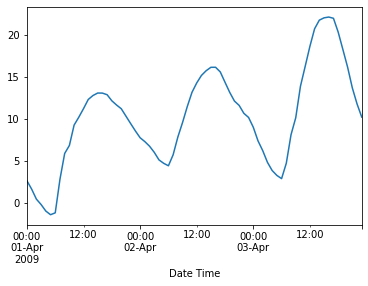

In [64]:
data = df.copy()
data["Date Time"] = pd.to_datetime(data["Date Time"],format="%d.%m.%Y %H:%M:%S")
data.set_index("Date Time",inplace=True)
data = data.resample("1h").mean()

series = data[['T (degC)', "p (mbar)"]]
series.rename(columns={'T (degC)':"temp","p (mbar)":"p"},inplace=True)
series_section = series["2009-04-01":"2009-04-03"]
series_section["temp"].plot()

In [93]:
def getXandY(df_temp, start, stop):
    dataframe = scaler.transform(df_temp[start:stop])
    dataframe = pd.DataFrame(dataframe)
    
    dataframe = dataframe.rename(columns={0:"temperature"})
    dataframe.index = df_temp[start:stop].index

    dataframe_shifted = series_to_supervised(dataframe,Timesteps_past-1,Timesteps_future+1)

    X_dataframe = dataframe_shifted[dataframe_shifted.columns.drop(list(dataframe_shifted.filter(regex='\+')))]
    y_dataframe = dataframe_shifted.filter(regex='temperature\(t\+')

    X_dataframe = X_dataframe.to_numpy()
    y_dataframe = y_dataframe.to_numpy()

    X_dataframe = X_dataframe.reshape(X_dataframe.shape[0], Timesteps_past, Features) # (samples, time steps, features).

    print(X_dataframe.shape,y_dataframe.shape)

    return X_dataframe, y_dataframe, dataframe_shifted

In [201]:
from sklearn.preprocessing import MinMaxScaler

Timesteps_past = 24
Features = 2
Timesteps_future = 12


scaler = MinMaxScaler().fit(series["2009-01-01":"2009-12-31"])
scaler_for_rescale = MinMaxScaler().fit(series["2009-01-01":"2009-12-31"][["temp"]])

X_train, y_train, train_shifted = getXandY(series, "2009-01-01", "2010-12-31")
X_valid, y_valid, valid_shifted = getXandY(series, "2011-01-01", "2012-12-31")
X_test, y_test, test_shifted = getXandY(series, "2012-01-01", "2012-06-15")

(17485, 24, 2) (17485, 12)
(17509, 24, 2) (17509, 12)
(3973, 24, 2) (3973, 12)


In [202]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [203]:
from keras.layers.recurrent import LSTM

# define parameters
verbose, epochs, batch_size = 2, 5, 4

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
model.summary()
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                520       
_________________________________________________________________
dense_12 (Dense)             (None, 12)                132       
Total params: 652
Trainable params: 652
Non-trainable params: 0
_________________________________________________________________


In [204]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(X_valid, y_valid),callbacks=[earlystop])

Epoch 1/5
4372/4372 - 41s - loss: 0.0103 - val_loss: 0.0052
Epoch 2/5
4372/4372 - 38s - loss: 0.0046 - val_loss: 0.0050
Epoch 3/5
4372/4372 - 39s - loss: 0.0043 - val_loss: 0.0051
Epoch 4/5
4372/4372 - 38s - loss: 0.0040 - val_loss: 0.0039
Epoch 5/5
4372/4372 - 38s - loss: 0.0030 - val_loss: 0.0030


In [205]:
predictions = model.predict(X_test)

In [206]:
df_prediction = pd.DataFrame(predictions)
df_prediction.index = test_shifted.index

df_actual = test_shifted.filter(regex="temperature\(t\+")


In [207]:
import warnings
warnings.filterwarnings("ignore")

for col in df_prediction.columns:
    df_prediction[[col]] = scaler_for_rescale.inverse_transform(df_prediction[[col]])
for col in df_actual.columns:
    df_actual[[col]] = scaler_for_rescale.inverse_transform(df_actual[[col]])

In [208]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(df_prediction, df_actual)))
print('   Mean absolute error: {}'.format(mean_absolute_error(df_prediction, df_actual)))
print('   Coefficient of determination: {}'.format(r2_score(df_prediction, df_actual)))

Evaluation:
   Mean squared error: 10.139566544680289
   Mean absolute error: 2.4804039716965725
   Coefficient of determination: 0.8286635249790013


In [209]:
print("Evaluation:")
print('   Mean squared error: {}'.format(mean_squared_error(predictions, y_test)))
print('   Mean absolute error: {}'.format(mean_absolute_error(predictions, y_test)))
print('   Coefficient of determination: {}'.format(r2_score(predictions, y_test)))

Evaluation:
   Mean squared error: 109.22314548823606
   Mean absolute error: 8.949381387224781
   Coefficient of determination: -0.764944295766257


In [238]:
def transformTestData(y_test, colName):
    ydf = y_test.to_frame()
    df_compare = pd.DataFrame()
    list1 = []
    for i, row in enumerate(ydf.iterrows()):
        list1.append([pd.to_datetime(ydf.columns[0]) + datetime.timedelta(hours=(i+1)),
        ydf.iloc[i][0]])
    df_compare = df_compare.append(list1)
    df_compare = df_compare.set_index(0)
    df_compare.columns= [colName]
    return df_compare

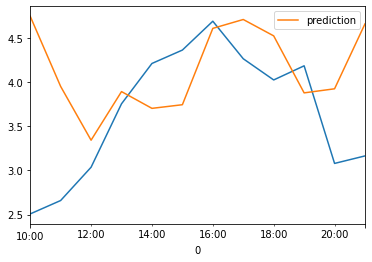

In [285]:
i = 130
a = transformTestData(df_actual.iloc[i],"actual")
for j in range(1):
  p = transformTestData(df_prediction.iloc[i+j],"prediction")
  ax1 = series["2012-01-01":"2012-06-15"]["temp"][i+24:i+12+24].plot()
  p.plot(ax=ax1)
  

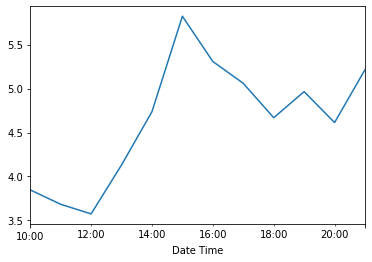

In [284]:
series["2011-01-01":"2011-06-15"]["temp"][i+24:i+12+24].plot()

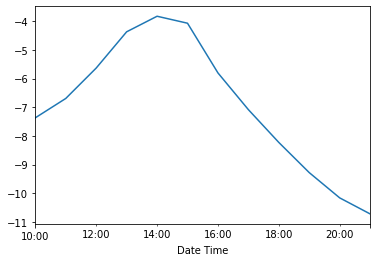

In [286]:
series["2010-01-01":"2010-06-15"]["temp"][i+24:i+12+24].plot()